# Gathering data

## Header

In [1]:
#header of imports
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.wcs import WCS

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip

from astropy import units as u
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture

import csv

import astrometry
import pandas as pd
import astropy.units as u

import astropy as ap

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={1,3},
    )
)

import logging
!pip install astroalign
from reproject import reproject_interp
from collections import defaultdict
from scipy.ndimage import shift as ndi_shift
from astropy.coordinates import SkyCoord, match_coordinates_sky

from astropy.visualization import PercentileInterval, AsinhStretch, ImageNormalize
import astroalign as aa
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Functions

In [2]:
#defining a function that corrects the bias:
def BiasCorrection(filenum):
    #Defining bias_image
    filename = 'bias.fits'
    hdu = fits.open(filename)[0]
    bias_image = hdu.data
    hdr = hdu.header

    #create a dictionary for the corrected files
    corrected = {}
    
    for i in range(1, filenum+1):
        filename = f'23feb.{i:04d}.fits'
        hdu = fits.open(filename)[0]
        image = hdu.data
        hdr = hdu.header
        
        #subtract and store in dictionary
        bias = image - bias_image
        filt = hdr.get('FILTER')
        exposure = hdr.get('EXPTIME')
        corrected[filename] = {
        'data': bias,
        'filter': filt,
        'exposure': exposure,
        'img': hdu
        }

    #returns the dictionary
    return corrected

In [3]:
#Defining function that flatfields:
def Flatfielding(corrected):
    #create a dictionary of the filters
    flatdict = {
        'Harris-R': 'rflat.fits',
        'Harris-V': 'vflat.fits',
        'Harris-B': 'bflat.fits',
        'Bessell-U': 'uflat.fits',
    }
    #interate across dict
    for file, info in corrected.items():
        data = info['data']
        filt = info['filter']
        #grab flat field fits
        flat = flatdict.get(filt)

        hdu = fits.open(flat)[0]
        flatdata = hdu.data
        
        info['flatdata'] = data / flatdata
    return corrected

In [4]:
#Defining function that finds background
def Background(corrected):
    for file, info in corrected.items():
        image = info['flatdata']
        mean, median, std = sigma_clipped_stats(image, sigma=3.0)
        sigma_clip = SigmaClip(sigma=3.0)
        bkg_estimator = MedianBackground()

        bkg = Background2D(image, (50, 50), filter_size=(3,3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)

        image = image - bkg.background
        info['bgsub'] = image
    return corrected

In [5]:
#Defining function that finds stars:
def Starfinding(corrected):
    #blank dictionary for star data
    tables = {}

    #goes through dictionary and uses code from workbook6
    for file, info in corrected.items():
        image = info['flatdata']
        
        bkg_sigma = mad_std(image)

        daofind = DAOStarFinder(fwhm=4.0, threshold=100.0 * bkg_sigma)

        sources = daofind(image)

        for col in sources.colnames:
            sources[col].info.format = '%.8g' 
            
        sources = sources[sources['ycentroid'] >= 1]
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

        radii = [3.0, 4.0, 5.0,7.0,10.0,15.0,25.0,40.0]

        apertures = [CircularAperture(positions, r=r) for r in radii]
        
        phot_table = aperture_photometry(image, apertures)
        #adds tables to the dictionary
        tables[file] = phot_table

    return tables, radii

In [6]:
#Define astropy function
def astropy(groups):
    logging.getLogger().setLevel(logging.INFO)
    unit = 'pix'
    for filt, trials in groups.items():
        for file, info in trials.items():
            x = info['position'][0]
            y = info['position'][1]
            stars = [(x[i], y[i]) for i in range(0,len(x))]
            solution = solver.solve(
                stars=stars,
                size_hint=None,
                position_hint=astrometry.PositionHint(
                    ra_deg=114.73,
                    dec_deg=38,
                    radius_deg=1.0),
        solution_parameters=astrometry.SolutionParameters(),
)    
            if solution.has_match():
                info['wcs'] = solution.best_match().astropy_wcs()
    return groups

In [7]:
#define stacking function
def stacking(filt):
    ref_file, first_info = next(iter(filt.items()))
    ref_wcs   = first_info['wcs']
    ref_shape = first_info['data'].shape
    reprojected = []
    for files, file in filt.items():
        data = file['flatdata']
        wcs = file['wcs']
        dataproj, _ = reproject_interp((data, wcs), ref_wcs,shape_out=ref_shape)
        reprojected.append(dataproj)
    stack = np.median(np.stack(reprojected, axis=0), axis=0)
    hdu = fits.PrimaryHDU(stack, header=ref_wcs.to_header())
    out = f'stack_{files.replace(" ", "_")}.fits'
    hdu.writeto(out, overwrite=True)
    print(f"Wrote {out}, shape = {stack.shape}")
    bkg = Background2D(image, box_size=(50, 50), filter_size=(3, 3), bkg_estimator=MedianBackground())
    data = stack - bkg.background
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    print("min, max, mean:", np.nanmin(stack), np.nanmax(stack), np.nanmean(stack))
        # 3) Run DAOStarFinder at 5σ above background
    daofind = DAOStarFinder(fwhm=4.0, threshold=50.0 * std)
    sources = daofind(data)
    for col in sources.colnames:
        sources[col].info.format = '%.8g' 
            
    sources = sources[sources['ycentroid'] >= 1]
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    radii = [3.0, 4.0, 5.0,7.0,10.0,15.0,25.0,40.0]

    apertures = [CircularAperture(positions, r=r) for r in radii]
        
    phot_table = aperture_photometry(stack, apertures)  

    solution = solver.solve(
            stars=stars,
            size_hint=None,
            position_hint=astrometry.PositionHint(
                ra_deg=114.73,
                dec_deg=38,
                radius_deg=1.0),
            solution_parameters=astrometry.SolutionParameters(),
        )    
        
        # defines new wcs reference frame using solved for values
        
    if solution.has_match():
            wcs = solution.best_match().astropy_wcs()
    if solution.has_match():
        for star in solution.best_match().stars:
            print(f"{star.ra_deg}, {star.dec_deg}:") 
            print(star)  # Often this dumps the available fields
    if solution.has_match():
        wcs = solution.best_match().astropy_wcs()
        pixels = wcs.all_world2pix(
            [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
            0,
        )
    
    norm = ImageNormalize(
        stack,
        interval=PercentileInterval(99.5),
        stretch=AsinhStretch()
    )
    
    fig = plt.figure(figsize=(20,20))
    ax  = fig.add_subplot(projection=wcs)
    
    # draw the stretched image
    im = ax.imshow(
        stack,
        origin='lower',
        norm=norm,
        cmap='viridis'
    )
    ax.grid(color='white', ls='solid', alpha=1)
    ax.set_xlabel('Right Ascension', fontsize=24)
    ax.set_ylabel('Declination',    fontsize=24)
    fig.colorbar(im, ax=ax, label='counts')
    plt.show()
    header = hdu.header
    wcs    = WCS(header)
    return stack, header, wcs, phot_table

In [8]:
#new stacking
def Stack(filt):
    ref_file, first_info = next(iter(filt.items()))
    ref_wcs   = first_info['wcs']
    ref_shape = first_info['flatdata'].shape
    img_aligned = first_info['flatdata']
    for  files, file in filt.items():
        img = file['flatdata']
        img_aligned, _ = aa.register(img_aligned, img, detection_sigma=3.0)
    return img_aligned

In [9]:
def hlr(image, x0, y0):
    y, x = np.indices(image.shape)
    r = np.hypot(x - x0, y - y0)
    dr = 1.0
    
    r_max = np.min([x0, y0, image.shape[0]-y0, image.shape[1]-x0])

    radii = np.arange(0, r_max, dr)
    cumflux = np.array([np.nansum(image[r <= rad]) for rad in radii])

    total_flux = cumflux[-1]
    half_flux = total_flux / 2.0

    idx = np.searchsorted(cumflux, half_flux)
    R_half = radii[idx]

    plt.figure(figsize=(6,4))
    plt.plot(radii, cumflux, 'o-', label='Curve of Growth')
    plt.axvline(R_half, color='red', linestyle='--', label=f'R₁/₂ = {R_half:.1f} px')
    plt.xlabel("Radius (pixels)")
    plt.ylabel("Cumulative Flux")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return R_half

In [16]:
def mass(r_half):
    plate_scale = 0.15  # arcsec/pix
    distance   = 88500  # pc (distance to NGC2419)
    r_pix = r_half        # half-light radius in px from your code
    
    # convert to arcsec
    r_arcsec = r_pix * plate_scale
    # convert to radians
    r_rad = (r_arcsec * u.arcsec).to(u.rad).value
    # physical radius (pc)
    r_pc = distance * r_rad
    
    # constants
    G = 4.302e-3    # pc·(km/s)^2 / M_sun
    
    # your measured values
    hlr_pc = r_pc     # from earlier: physical half-light radius in pc
    sigma = 3.7       # km/s, e.g. from your spectra
    
    # Wolf et al. mass estimator
    M_half = 4 * sigma**2 * hlr_pc / G
    
    print(f"M_1/2 = {M_half:.2e} M_sun")
    print(f"M_1/2*2 = {M_half*2.0:.2e} M_sun")

## Running Code

In [28]:
#running some code
corrected = BiasCorrection(56)
corrected = Flatfielding(corrected)
tables, radii = Starfinding(corrected)

In [29]:
#group starfinding info with files and files with filters
groups = {
        'Harris-R': {},
        'Harris-V': {},
        'Harris-B': {},
        'Bessell-U': {}
    }
for file, info in corrected.items():
        filt = info['filter']
        tbl = tables[file]
        x = tbl['xcenter'].value    
        y = tbl['ycenter'].value  
        if filt == 'Harris-R':
            groups[filt][file] = info
        elif filt == 'Harris-V':
            groups[filt][file] = info
        elif filt == 'Harris-B':
            groups[filt][file] = info
        elif filt == 'Bessell-U':
            groups[filt][file] = info
        groups[filt][file]['position']=[x,y]

In [30]:
#LONG CODE RUNS ASTROPY FOR EACH FILE AND STORES WCS
groups = astropy(groups)

INFO:root:solve 1: start
INFO:root:solve 1: slice=[0, 25) (1 / 1), index="5200/index-5201-05.fits" (1 / 2)
INFO:root:solve 1: logodds=142.777, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8879, scale=0.425611, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=143.271, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8879, scale=0.424874, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=134.66, matches=24, conflicts=0, distractors=4, ra=114.538, dec=38.8881, scale=0.428704, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=144.971, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8883, scale=0.42792, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=151.965, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.888, scale=0.425242, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=148.687, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.888, scale=0.427714, index="5200/index-5201-05.fits"
INF

<frozen importlib._bootstrap>:241: FutureWarning: 
The `sep-pjw` package has reverted to the original `sep` package name. Bug
fixes and additional enhancements will not be released for `sep-pjw`, and
users of this package should update their dependencies to `sep>=1.4.0`.



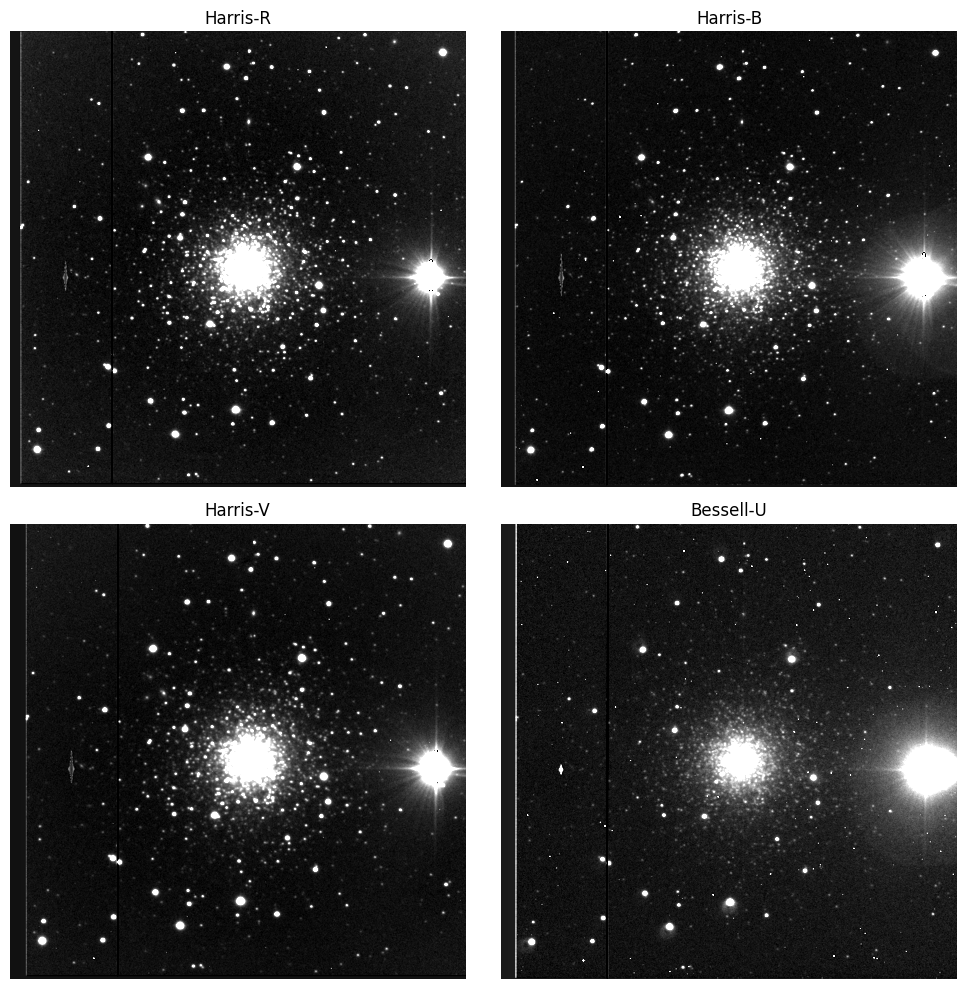

In [31]:
HR = Stack(groups['Harris-R'])
HB = Stack(groups['Harris-B'])
HV = Stack(groups['Harris-V'])
BU = Stack(groups['Bessell-U'])

stacks = {
    'Harris-R': HR,
    'Harris-B': HB,
    'Harris-V': HV,
    'Bessell-U': BU
}

# Compute vmin and vmax
Rvmin, Rvmax = np.percentile(HR, (2, 98))
Rnorm = ImageNormalize(vmin=Rvmin, vmax=Rvmax)
Bvmin, Bvmax = np.percentile(HB, (2, 98))
Bnorm = ImageNormalize(vmin=Bvmin, vmax=Bvmax)
Vvmin, Vvmax = np.percentile(HV, (2, 98))
Vnorm = ImageNormalize(vmin=Vvmin, vmax=Vvmax)
Uvmin, Uvmax = np.percentile(BU, (2, 98))
Unorm = ImageNormalize(vmin=Uvmin, vmax=Uvmax)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(HR, cmap='gray', norm=Rnorm, origin='lower')
axes[0, 0].set_title("Harris-R")
axes[0, 0].axis('off')

axes[0, 1].imshow(HB, cmap='gray', norm=Bnorm, origin='lower')
axes[0, 1].set_title("Harris-B")
axes[0, 1].axis('off')

axes[1, 0].imshow(HV, cmap='gray', norm=Vnorm, origin='lower')
axes[1, 0].set_title("Harris-V")
axes[1, 0].axis('off')

axes[1, 1].imshow(BU, cmap='gray', norm=Unorm, origin='lower')
axes[1, 1].set_title("Bessell-U")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

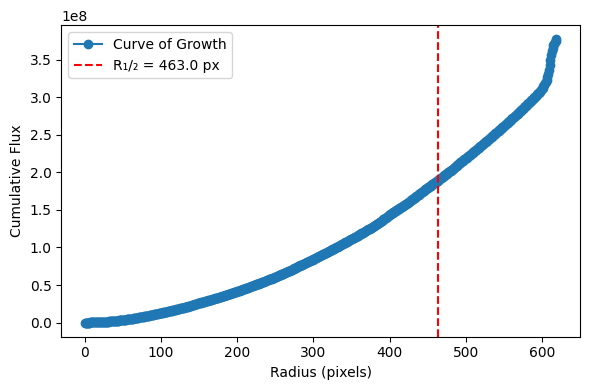

Half-light radius: 463.0 pixels


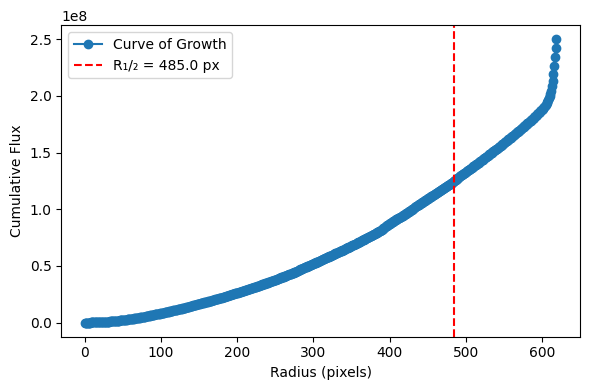

Half-light radius: 485.0 pixels


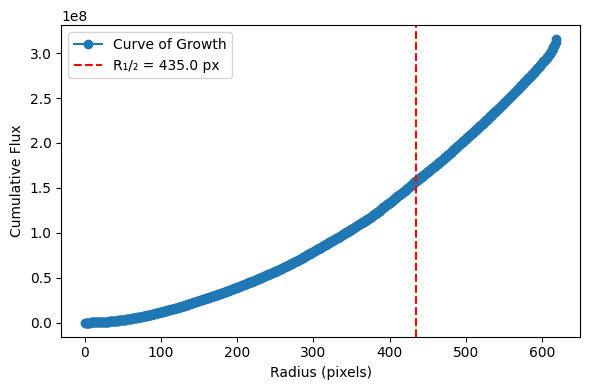

Half-light radius: 435.0 pixels


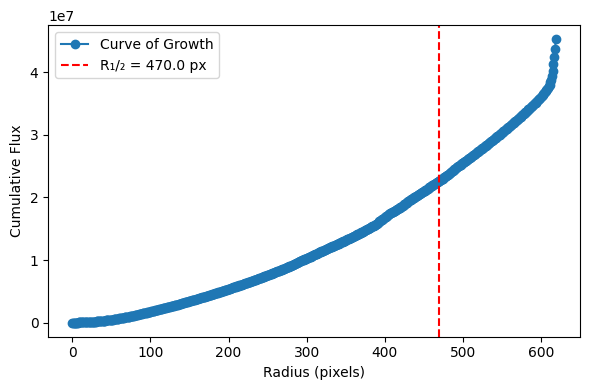

Half-light radius: 470.0 pixels


In [33]:
Rhalf = hlr(HR, x0=650, y0=620)
print(f"Half-light radius: {Rhalf:.1f} pixels")
Bhalf = hlr(HB, x0=650, y0=620)
print(f"Half-light radius: {Bhalf:.1f} pixels")
Vhalf = hlr(HV, x0=650, y0=620)
print(f"Half-light radius: {Vhalf:.1f} pixels")
Uhalf = hlr(BU, x0=650, y0=620)
print(f"Half-light radius: {Uhalf:.1f} pixels")

In [35]:
mass(Rhalf)
mass(Bhalf)
mass(Vhalf)
mass(Uhalf)

M_1/2 = 3.79e+05 M_sun
M_1/2*2 = 7.59e+05 M_sun
M_1/2 = 3.97e+05 M_sun
M_1/2*2 = 7.95e+05 M_sun
M_1/2 = 3.56e+05 M_sun
M_1/2*2 = 7.13e+05 M_sun
M_1/2 = 3.85e+05 M_sun
M_1/2*2 = 7.70e+05 M_sun
